# Sentiment Analysis of Amazon Reviews: Classical NLP vs Neural Networks
Online product reviews influence purchasing decisions, but manually reading thousands of reviews is impractical. That is why this project builds and compares multiple machine learning approaches to classify review sentiment (positive vs negative).

## Goals
- Build baseline NLP models using Bag-of-Words and TF-IDF
- Implement a neural network using PyTorch
- Compare performance, complexity, and tradeoffs

### Installing Libraries

In [1]:
# Core
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Embeddings
import gensim.downloader as api
from sklearn.decomposition import PCA

torch.manual_seed(42)
np.random.seed(42)


Matplotlib is building the font cache; this may take a moment.

A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/urvisharma/.pyenv/versions/3.12.4/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/urvisharma/.pyenv/versions/3.12.4/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/urvisharma/.pyenv/versions/3.12.4/

## Dataset Overview
The dataset contains Amazon reviews including review text and ratings.

Preprocessing:
- Extract numeric ratings from text
- Remove neutral reviews (rating = 3)
- Convert ratings into binary sentiment labels:
    - 1–2 stars → Negative
    - 4–5 stars → Positive

In [2]:
df = pd.read_csv("../data/Amazon_Reviews.csv", engine="python")

In [3]:
df.head()

,Reviewer Name,Profile Link,Country,Review Count,Review Date,Rating,Review Title,Review Text,Date of Experience
0,Eugene ath,/users/66e8185ff1598352d6b3701a,US,1 review,2024-09-16T13:44:26.000Z,Rated 1 out of 5 stars,A Store That Doesn't Want to Sell Anything,"I registered on the website, tried to order a ...","September 16, 2024"
1,Daniel ohalloran,/users/5d75e460200c1f6a6373648c,GB,9 reviews,2024-09-16T18:26:46.000Z,Rated 1 out of 5 stars,Had multiple orders one turned up and…,Had multiple orders one turned up and driver h...,"September 16, 2024"
2,p fisher,/users/546cfcf1000064000197b88f,GB,90 reviews,2024-09-16T21:47:39.000Z,Rated 1 out of 5 stars,I informed these reprobates,I informed these reprobates that I WOULD NOT B...,"September 16, 2024"
3,Greg Dunn,/users/62c35cdbacc0ea0012ccaffa,AU,5 reviews,2024-09-17T07:15:49.000Z,Rated 1 out of 5 stars,Advertise one price then increase it on website,I have bought from Amazon before and no proble...,"September 17, 2024"
4,Sheila Hannah,/users/5ddbe429478d88251550610e,GB,8 reviews,2024-09-16T18:37:17.000Z,Rated 1 out of 5 stars,If I could give a lower rate I would,If I could give a lower rate I would! I cancel...,"September 16, 2024"


In [4]:
df.columns

Index(['Reviewer Name', 'Profile Link', 'Country', 'Review Count',
       'Review Date', 'Rating', 'Review Title', 'Review Text',
       'Date of Experience'],
      dtype='str')

## Text Preprocessing
Text is transformed into numerical features using:
- Bag-of-Words
- TF-IDF

Allows logistic regression to learn patterns from word frequency.

In [5]:
df["Rating"] = df["Rating"].str.extract(r"Rated (\d)")
df = df.dropna(subset=["Rating"])
df["Rating"] = df["Rating"].astype(int)

In [7]:
df = df[df.Rating != 3] #remove neutral reviews
df['label'] = df.Rating.apply(lambda x: 1 if x >= 4 else 0) #any review greater than 4 is labelled as 1 (positive)

df.head(5)


,Reviewer Name,Profile Link,Country,Review Count,Review Date,Rating,Review Title,Review Text,Date of Experience,label
0,Eugene ath,/users/66e8185ff1598352d6b3701a,US,1 review,2024-09-16T13:44:26.000Z,1,A Store That Doesn't Want to Sell Anything,"I registered on the website, tried to order a ...","September 16, 2024",0
1,Daniel ohalloran,/users/5d75e460200c1f6a6373648c,GB,9 reviews,2024-09-16T18:26:46.000Z,1,Had multiple orders one turned up and…,Had multiple orders one turned up and driver h...,"September 16, 2024",0
2,p fisher,/users/546cfcf1000064000197b88f,GB,90 reviews,2024-09-16T21:47:39.000Z,1,I informed these reprobates,I informed these reprobates that I WOULD NOT B...,"September 16, 2024",0
3,Greg Dunn,/users/62c35cdbacc0ea0012ccaffa,AU,5 reviews,2024-09-17T07:15:49.000Z,1,Advertise one price then increase it on website,I have bought from Amazon before and no proble...,"September 17, 2024",0
4,Sheila Hannah,/users/5ddbe429478d88251550610e,GB,8 reviews,2024-09-16T18:37:17.000Z,1,If I could give a lower rate I would,If I could give a lower rate I would! I cancel...,"September 16, 2024",0


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    df['Review Text'],
    df['label'],
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)


## Baseline Model: Bag-of-Words + Logistic Regression

Logistic regression is used as a strong baseline because:
- It performs well on sparse text data
- It is computationally efficient
- Results are interpretable compared to deep learning models

In [9]:
bow_vectorizer = CountVectorizer(
    max_features=10000,
    stop_words='english',
    ngram_range=(1,2)
)

X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

bow_model = LogisticRegression(max_iter=1000)
bow_model.fit(X_train_bow, y_train)

bow_preds = bow_model.predict(X_test_bow)

print("BOW Accuracy:", accuracy_score(y_test, bow_preds))
print(classification_report(y_test, bow_preds))


BOW Accuracy: 0.9323252354982647
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      2870
           1       0.86      0.91      0.89      1164

    accuracy                           0.93      4034
   macro avg       0.91      0.93      0.92      4034
weighted avg       0.93      0.93      0.93      4034



## Improved Representation: TF-IDF

TF-IDF reduces the impact of extremely common words and emphasizes informative terms.
This often improves performance over raw word counts.

In [10]:
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,
    stop_words='english',
    ngram_range=(1,2)
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

tfidf_model = LogisticRegression(max_iter=1000)
tfidf_model.fit(X_train_tfidf, y_train)

tfidf_preds = tfidf_model.predict(X_test_tfidf)

print("TF-IDF Accuracy:", accuracy_score(y_test, tfidf_preds))
print(classification_report(y_test, tfidf_preds))


TF-IDF Accuracy: 0.9305899851264254
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      2870
           1       0.91      0.84      0.87      1164

    accuracy                           0.93      4034
   macro avg       0.93      0.90      0.91      4034
weighted avg       0.93      0.93      0.93      4034



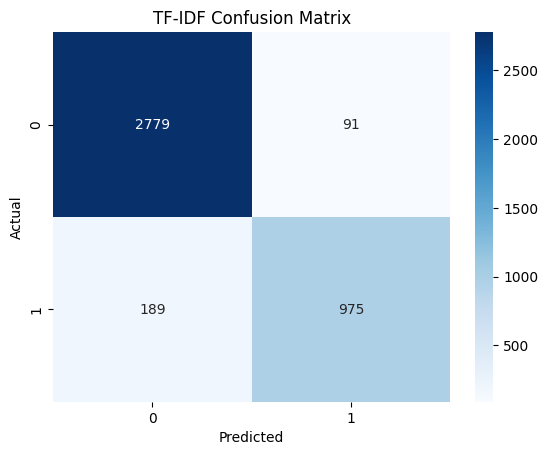

In [11]:
cm = confusion_matrix(y_test, tfidf_preds)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("TF-IDF Confusion Matrix")


plt.savefig("../outputs/confusion_matrix.png", bbox_inches="tight", dpi=300)

plt.show()


## Neural Network Model

A feedforward neural network is trained using TF-IDF features.

Architecture:
- Dense layer (256 units) → ReLU
- Dense layer (64 units) → ReLU
- Output layer with Sigmoid activation

The goal is to test whether a deeper model provides meaningful improvements over classical methods.

In [12]:
X_train_tensor = torch.tensor(X_train_tfidf.toarray(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_tfidf.toarray(), dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


In [13]:
class ReviewNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

model = ReviewNN(X_train_tensor.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [14]:
epochs = 10
losses = []

for epoch in range(epochs):
    epoch_loss = 0

    for xb, yb in train_loader:
        optimizer.zero_grad()

        preds = model(xb).squeeze()
        loss = criterion(preds, yb)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    losses.append(epoch_loss)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")


Epoch 1, Loss: 65.9331
Epoch 2, Loss: 22.8951
Epoch 3, Loss: 12.5708
Epoch 4, Loss: 8.3746
Epoch 5, Loss: 6.3740
Epoch 6, Loss: 5.6271
Epoch 7, Loss: 5.2170
Epoch 8, Loss: 5.1571
Epoch 9, Loss: 4.9995
Epoch 10, Loss: 4.9169


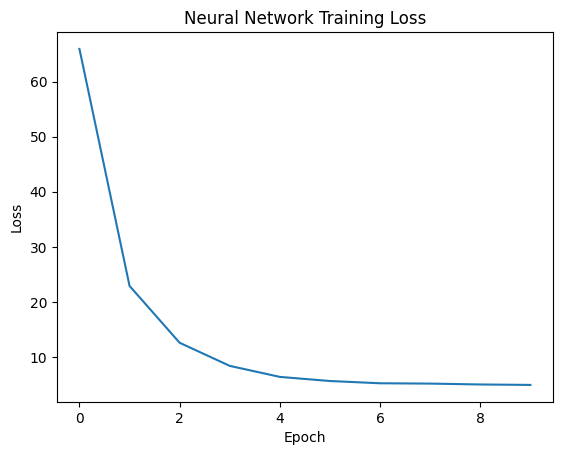

In [15]:
plt.plot(losses)
plt.title("Neural Network Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.savefig("../outputs/loss_curve.png", bbox_inches="tight", dpi=300)
plt.show()

In [16]:
model.eval()
with torch.no_grad():
    test_preds = model(X_test_tensor).squeeze()
    predicted = (test_preds > 0.5).float()

accuracy = (predicted == y_test_tensor).float().mean()
print("Neural Network Accuracy:", accuracy.item())


Neural Network Accuracy: 0.9266237020492554


## Model Comparison and Critical Analysis

Performance Summary:
- Bag-of-Words Logistic Regression: ~93% accuracy
- TF-IDF Logistic Regression: ~93% accuracy
- Neural Network: ~92–93% accuracy

Key Observations:
1. Classical models performed just as well as the nn
2. TF-IDF slightly improved precision but reduced recall for positive reviews
3. The neural network had more complexity without performance gains

Why this happens:
- TF-IDF features are already high dimensional and informative.
- Logistic regression often performs extremely well on text classification tasks.
- Neural networks require significantly more data or contextual embeddings to outperform linear models.

Tradeoffs:
- Logistic Regression → Fast, interpretable, production-friendly
- Neural Network → More flexible but harder to tune

Limitations:
- Binary removes neutral sentiment
- No deep semantic embeddings (e.g., BERT)

Future Improvements:
- Use pretrained embeddings (Word2Vec/BERT)
- Hyperparameter tuning
- Analysis on misclassified reviews